#Análisis de la varianza (ANOVA)
La prueba t funciona bien cuando se trata de dos grupos, pero a veces queremos comparar más de dos grupos al mismo tiempo. Por ejemplo, si quisiéramos probar si la edad de los votantes difiere en función de alguna variable categórica como la raza, tenemos que comparar las medias de cada nivel o agrupar la variable. Podríamos realizar una prueba t separada para cada par de grupos, pero cuando se realiza muchas pruebas, aumenta las posibilidades de falsos positivos. El análisis de varianza o ANOVA es una prueba de inferencia estadística que le permite comparar varios grupos al mismo tiempo.

El ANOVA unidireccional prueba si la media de alguna variable numérica difiere entre los niveles de una variable categórica. Esencialmente responde a la pregunta: ¿alguna de las medias grupales difiere entre sí? ¿Hay alguna muestra diferente al resto? No entraremos en los detalles de realizar un ANOVA a mano, ya que implica más cálculos que la prueba t, pero el proceso es similar: realiza varios cálculos para llegar a una estadística de prueba y luego compara el estadísticoa a un valor crítico basado en una distribución de probabilidad. En el caso del ANOVA, se utiliza la distribución F de Snedecor.

La biblioteca scipy tiene una función para realizar pruebas ANOVA unidireccionales llamada scipy.stats.f_oneway(). 

Generemos algunos datos demográficos y de edad de votantes falsos y usemos el ANOVA para comparar las edades promedio entre los grupos:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
np.random.seed(12)

races =   ["asian","black","hispanic","other","white"]

# Generate random data
voter_race = np.random.choice(a= races,
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

voter_age = stats.poisson.rvs(loc=18,
                              mu=30,
                              size=1000)

# Group age data by race
voter_frame = pd.DataFrame({"race":voter_race,"age":voter_age})
groups = voter_frame.groupby("race").groups

# Extract individual groups
asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

# Perform the ANOVA
stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=1.7744689357329695, pvalue=0.13173183201930463)

El resultado de la prueba arroja una estadística F de 1,774 y un valor p de 0,1317, lo que indica que no hay una diferencia significativa entre las medias de cada grupo.

Otra forma de realizar una prueba ANOVA es utilizar la biblioteca statsmodels, que permite especificar un modelo con una sintaxis de fórmula que refleja la utilizada por el lenguaje de programación R. Los usuarios de R pueden encontrar este método más familiar:

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('age ~ race',                 # Model formula
            data = voter_frame).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

             sum_sq     df         F    PR(>F)
race        199.369    4.0  1.774469  0.131732
Residual  27948.102  995.0       NaN       NaN


Como puede ver, el método statsmodels produjo la misma estadística F y valor P (enumerados como PR(<F)) que el método stats.f_oneway.

Ahora hagamos datos de la nueva era donde las medias del grupo difieren y ejecutemos un segundo ANOVA:

In [4]:
np.random.seed(12)

# Generate random data
voter_race = np.random.choice(a= races,
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

# Use a different distribution for white ages
white_ages = stats.poisson.rvs(loc=18, 
                              mu=32,
                              size=1000)

voter_age = stats.poisson.rvs(loc=18,
                              mu=30,
                              size=1000)

voter_age = np.where(voter_race=="white", white_ages, voter_age)

# Group age data by race
voter_frame = pd.DataFrame({"race":voter_race,"age":voter_age})
groups = voter_frame.groupby("race").groups   

# Extract individual groups
asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

# Perform the ANOVA
stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=10.164699828386366, pvalue=4.5613242113994585e-08)

In [5]:
# Alternate method
model = ols('age ~ race',                 # Model formula
            data = voter_frame).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)


                sum_sq     df        F        PR(>F)
race       1284.123213    4.0  10.1647  4.561324e-08
Residual  31424.995787  995.0      NaN           NaN


El resultado de la prueba sugiere que los grupos no tienen las mismas medias muestrales en este caso, ya que el valor p es significativo con un nivel de confianza del 99 %. Sabemos que son los votantes blancos los que difieren porque lo configuramos de esa manera en el código, pero al probar datos reales, es posible que no sepa qué grupo o grupos hicieron que la prueba arrojara un resultado positivo. 
Para verificar qué grupos difieren después de obtener un resultado ANOVA positivo, se puede realizar una prueba de seguimiento o "prueba post-hoc".

Una prueba post-hoc es realizar una prueba t separada para cada par de grupos. Puede realizar una prueba t entre todos los pares ejecutando cada par a través de stats.ttest_ind() que cubrimos en la lección sobre pruebas t:

In [6]:
# Get all race pairs
race_pairs = []

for race1 in range(4):
    for race2  in range(race1+1,5):
        race_pairs.append((races[race1], races[race2]))

# Conduct t-test on each pair
for race1, race2 in race_pairs: 
    print(race1, race2)
    print(stats.ttest_ind(voter_age[groups[race1]], 
                          voter_age[groups[race2]]))

asian black
Ttest_indResult(statistic=0.838644690974798, pvalue=0.4027281369339345)
asian hispanic
Ttest_indResult(statistic=-0.42594691924932293, pvalue=0.6704669004240726)
asian other
Ttest_indResult(statistic=0.9795284739636, pvalue=0.3298877500095151)
asian white
Ttest_indResult(statistic=-2.318108811252288, pvalue=0.020804701566400217)
black hispanic
Ttest_indResult(statistic=-1.9527839210712925, pvalue=0.05156197171952594)
black other
Ttest_indResult(statistic=0.28025754367057176, pvalue=0.7795770111117659)
black white
Ttest_indResult(statistic=-5.379303881281835, pvalue=1.039421216662395e-07)
hispanic other
Ttest_indResult(statistic=1.5853626170340225, pvalue=0.11396630528484335)
hispanic white
Ttest_indResult(statistic=-3.5160312714115376, pvalue=0.0004641298649066684)
other white
Ttest_indResult(statistic=-3.763809322077872, pvalue=0.00018490576317593065)


Los valores p para cada prueba t por pares sugieren que la media de los votantes blancos es probablemente diferente de los otros grupos, ya que los valores p para cada prueba t que involucra al grupo blanco es inferior a 0,05. Sin embargo, el uso de pruebas t por pares no ajustadas puede sobrestimar la importancia, porque cuantas más comparaciones haga, más probable es que encuentre un resultado poco probable debido a la casualidad. Podemos ajustar este problema de comparación múltiple dividiendo el nivel de significación estadística por el número de comparaciones realizadas. En este caso, si estuviéramos buscando un nivel de significación del 5 %, estaríamos buscando valores de p de 0,05/10 = 0,005 o menos. Este ajuste simple para comparaciones múltiples se conoce como la corrección de Bonferroni.

La corrección de Bonferroni es un enfoque conservador para dar cuenta del problema de comparaciones múltiples que puede terminar rechazando resultados que en realidad son significativos. Otra prueba post hoc común es la prueba de Tukey. Puede realizar la prueba de Tukey usando la función pairwise_tukeyhsd() en la biblioteca statsmodels.stats.multicomp:

/usr/local/lib/python3.8/dist-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


group1,group2,meandiff,p-adj,lower,upper,reject
asian,black,-0.8032,0.9,-3.4423,1.836,False
asian,hispanic,0.4143,0.9,-2.1011,2.9297,False
asian,other,-1.0645,0.8852,-4.2391,2.11,False
asian,white,1.9547,0.175,-0.4575,4.3668,False
black,hispanic,1.2175,0.2318,-0.386,2.821,False
black,other,-0.2614,0.9,-2.7757,2.253,False
black,white,2.7579,0.001,1.3217,4.194,True
hispanic,other,-1.4789,0.4391,-3.863,0.9053,False
hispanic,white,1.5404,0.004,0.3468,2.734,True
other,white,3.0192,0.0028,0.7443,5.2941,True


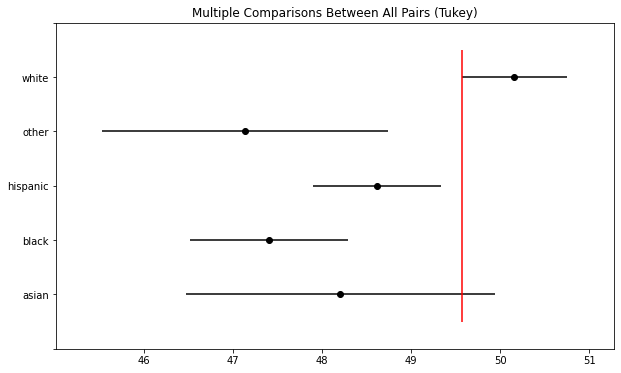

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=voter_age,     # Data
                          groups=voter_race,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey.summary()              # See test summary

El resultado de la prueba de Tukey muestra la diferencia promedio, un intervalo de confianza y si debe rechazar la hipótesis nula para cada par de grupos en el nivel de significación dado. En este caso, la prueba sugiere que rechacemos la hipótesis nula para 3 pares, y cada par incluye la categoría "blanca". Esto sugiere que el grupo blanco probablemente sea diferente de los demás. La gráfica del intervalo de confianza del 95 % refuerza los resultados visualmente: solo el intervalo de confianza de otro grupo se superpone al intervalo de confianza del grupo blanco.

#Resumen

La prueba ANOVA nos permite comprobar si una variable de respuesta numérica varía según los niveles de una variable categórica. La biblioteca scipy de Python facilita la realización de un ANOVA sin profundizar demasiado en los detalles del procedimiento.